<h1 style="text-align: center;"> Classification of Human Facial Expressions </h1>

<div style="display: flex; justify-content: space-around;">

<div style="width: 30%; text-align: center;">
<strong>Santiago Becerra Cordoba</strong>  
<br>
sab1475@g.harvard.edu
</div>

<div style="width: 30%; text-align: center;">
<strong>Sarah Kim</strong>  
<br>
gak604@g.harvard.edu
</div>


<div style="display: flex; justify-content: space-around;">

<div style="width: 30%; text-align: center;">
<strong>Chloe Seo</strong>  
<br>
yes593@g.harvard.edu
</div>

<div style="width: 30%; text-align: center;">
<strong>Kaylee Vo</strong>  
<br>
kav418@g.harvard.edu
</div>

<div style="display: flex; justify-content: space-around;">

<div style="width: 30%; text-align: center;">
<strong>Jie Zhao</strong>  
<br>
jiz273@g.harvard.edu
</div>

<div style="width: 30%; text-align: center;">
<strong></strong>  
<br>
</div>

<h5 style="text-align: center;"> ALM Data Science, Harvard University </h5>

## Table of Contents

1. [Introduction](#introduction)
    - [a. Access](#access)
    - [b. Load](#load)
    - [c. Understand](#understand)

2. [Preprocessing](#preprocessing)
    - [a. Missing Data](#missing-data)
    - [b. Data Imbalance](#data-imbalance)
    - [c. Denoising](#denoising)
    - [d. Feature Scaling](#feature-scaling)

3. [Sources](#sources)

4. [Appendix](#appendix)


## Data Overview

In this project, we aim to classify human facial expressions using a dataset of images. The data we will use is the FER-2013 dataset, which contains 35,887 grayscale images of size 48x48 pixels. Each image is labeled with one of seven emotions: anger, disgust, fear, happiness, sadness, surprise, and neutral. The data itself came with a train and test set. We split the train set into a train and validation set with 20% of the data going to the validation set.

The introduction has three sections: access, load, and understand. In the access section, we perform data engineering tasks to pull the data and prep the local directory structure. The data is too large to be kept in a repository, so this step is necessary for development. In the load section, we load the data into memory with Keras image generators. Finally in the Understand section, we sample a subset of images and present simple summaries and visualizations to better understand the data.

### Access

For this section we import libraries and write code to automatically pull the data from the internet. The code fetches from Kaggle and stores it in the users' cache. The code that moves the data from the cache to the project directory.

In [43]:
import os
import pathlib
import time
import zipfile
import random
import imageio
from matplotlib import cm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
import time
import tarfile
import gdown
from PIL import Image
import requests
import scipy.ndimage as ndimage
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Activation, BatchNormalization
from tensorflow.keras.layers import Conv2D, Dense, Dropout, GaussianNoise
from tensorflow.keras.layers import Flatten, Input, InputLayer, MaxPooling2D, GlobalAveragePooling2D, Reshape
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import L1, L2
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tqdm
import shutil
import platform
import cv2
import kagglehub
from keras.utils import set_random_seed

from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler

In [3]:
# Download latest version
path = kagglehub.dataset_download("msambare/fer2013")
print("Path to dataset files:", path)

Path to dataset files: /Users/santiagobecerracordoba/.cache/kagglehub/datasets/msambare/fer2013/versions/1


In [4]:
DATA_DIR = os.getcwd() + "/data"

# For mac users
if platform.system() == "Darwin":
    os.system('find . -name ".DS_Store" -delete')

if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)

In [5]:
# if data folder is empty, copy files from the dataset folder
if not os.listdir(DATA_DIR):
    for item in os.listdir(path):
        item_path = os.path.join(path, item)

        if os.path.isfile(item_path):
            shutil.copy(item_path, DATA_DIR)
            print(f"Copied file: {item_path}")
        elif os.path.isdir(item_path):
            shutil.copytree(item_path, os.path.join(DATA_DIR, item))
            print(f"Copied directory: {item_path}")

### Load

The data was already given in a directory structure. We leverage this in order loading code. After a 20% validaiton split, we have 22968 images in the training set, 5741 images in the validation set, and 7178 images in the test set. The total number of images is 35887. The images are scaled by dividing by 255. Note this is arbitrary for now and may be adjusted in the future.

In [6]:
train_dir = DATA_DIR + "/train"
val_dir = DATA_DIR + "/validation"
val_split = 0.2
random.seed(109)

if not os.path.exists(val_dir):
    os.makedirs(val_dir, exist_ok=True)
    for class_name in os.listdir(train_dir):
        class_path = os.path.join(train_dir, class_name)
        val_class_path = os.path.join(val_dir, class_name)
        os.makedirs(val_class_path, exist_ok=True)

        # List all images in the class directory
        images = os.listdir(class_path)
        random.shuffle(images)

        # Move a portion of images to validation
        num_val = int(len(images) * val_split)
        for img in images[:num_val]:
            shutil.move(
                os.path.join(class_path, img), os.path.join(val_class_path, img)
            )

In [7]:
datagen = ImageDataGenerator(rescale=1.0 / 255)

In [8]:
batch_size = 32
target_size = (48, 48)  # generator can resize all images if we want

traingen = datagen.flow_from_directory(
    DATA_DIR + "/train",  # this is the target directory
    target_size=target_size,
    batch_size=batch_size,
    class_mode="sparse",
    color_mode="grayscale",
)
valgen = datagen.flow_from_directory(
    DATA_DIR + "/validation",
    target_size=target_size,
    batch_size=batch_size,
    class_mode="sparse",
    color_mode="grayscale",
)

testgen = datagen.flow_from_directory(
    DATA_DIR + "/test",
    target_size=target_size,
    batch_size=batch_size,
    shuffle=False,
    class_mode="sparse",
    color_mode="grayscale",
)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [9]:
total_images = traingen.samples + valgen.samples + testgen.samples

print("Total images in dataset:", total_images)

Total images in dataset: 35887


### Understand

The batch size is set to 32 but this is arbitrary and is subject to change. The dimensions of the images are 48x48 with a single channel (e.g. grayscale images). The number of classes is 7, corresponding to the 7 emotions. The mapping from integer to emotion is shown in a cell below. We also present a set of 8 images to preview the data. The images match well with their labels. One aspect to note is the existence of watermarks in some of the images. This is a potential source of noise in the data that will need to be addressed in the preprocessing step.

In [10]:
data_batch, labels_batch = next(traingen)
print("data batch shape:", data_batch.shape)
print("labels batch shape:", labels_batch.shape)

data batch shape: (32, 48, 48, 1)
labels batch shape: (32,)


In [11]:
class_indices = traingen.class_indices
class_labels = {v: k for k, v in class_indices.items()}

In [12]:
class_labels

{0: 'angry',
 1: 'disgust',
 2: 'fear',
 3: 'happy',
 4: 'neutral',
 5: 'sad',
 6: 'surprise'}

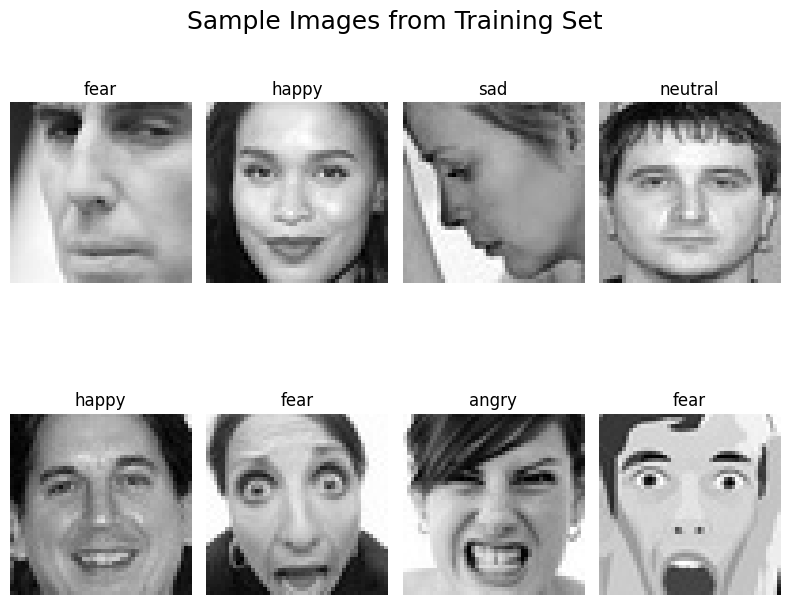

In [13]:
fig, ax = plt.subplots(2, 4, figsize=(8, 8))

axs = ax.ravel()

counter = 0
for batch, labels in traingen:
    for img, label in zip(batch, labels):
        class_index = int(label)
        class_name = class_labels[class_index]

        axs[counter].imshow(img[:, :, 0], cmap="gray")
        axs[counter].set_title(class_name)
        axs[counter].axis("off")

        counter += 1
        if counter >= 8:
            break

    break

plt.suptitle("Sample Images from Training Set", y=0.9, fontsize=18)
plt.tight_layout()

## Preprocessing

### Missing Data

In [14]:
traingen.reset()
testgen.reset()

missing_count_train = 0
total_pixels_train = 0
missing_count_test = 0
total_pixels_test = 0

for i in range(len(traingen)):
    batch_images, batch_labels = next(traingen)
    missing_count_train += np.isnan(batch_images).sum()
    total_pixels_train += batch_images.size

for i in range(len(testgen)):
    batch_images, batch_labels = next(testgen)
    missing_count_test += np.isnan(batch_images).sum()
    total_pixels_test += batch_images.size

print("--Training Set--")
print(f"Missing pixel values: {missing_count_train}")
print(f"Total pixels:         {total_pixels_train}")
if total_pixels_train > 0:
    pct_train = (missing_count_train / total_pixels_train) * 100
    print(f"Percentage missing:   {pct_train:.2f}%")
else:
    print("No pixels found")

print("\n--Test Set--")
print(f"Missing pixel values: {missing_count_test}")
print(f"Total pixels:         {total_pixels_test}")
if total_pixels_test > 0:
    pct_test = (missing_count_test / total_pixels_test) * 100
    print(f"Percentage missing:   {pct_test:.2f}%")
else:
    print("No pixels found")

if missing_count_train == 0 and missing_count_test == 0:
    print(
        "\nObservation: There are no missing pixel values in either training or test sets. "
    )
else:
    print("\nObservation: Some missing pixel values were found.")

--Training Set--
Missing pixel values: 0
Total pixels:         52918272
Percentage missing:   0.00%

--Test Set--
Missing pixel values: 0
Total pixels:         16538112
Percentage missing:   0.00%

Observation: There are no missing pixel values in either training or test sets. 


Checked through the training (traingen) and test (testgen) datasets for any missing pixel values by looping through every image batch and counting NaNs. As a result, there were no missing pixels found. 

### Data Imbalance

The training set shows clear class imbalance:

- **Underrepresented**:
  - *Disgust* (fewer than 1,000 images)
  - *Surprise*
- **Overrepresented**:
  - *Happy* (nearly 6,000 images)

This imbalance can bias the model toward majority classes and reduce accuracy on minority ones like *disgust* and *surprise*. To improve robustness and generalization, we applied data augmentation (e.g., rotation, zoom, flipping) to the entire training set. While this doesn’t rebalance class frequency, it helps prevent overfitting and exposes the model to more varied inputs.

If this approach proves insufficient, we’ll explore more targeted strategies—such as oversampling underrepresented classes or applying heavier augmentation selectively.

Additionally, we computed `class_weight` values to be used during model training. These weights adjust the loss function to penalize misclassifications of rare classes more heavily. For example, *disgust* has a weight of **9.4**, while *happy* has a weight of **0.57**. This encourages the model to pay more attention to minority classes during learning.

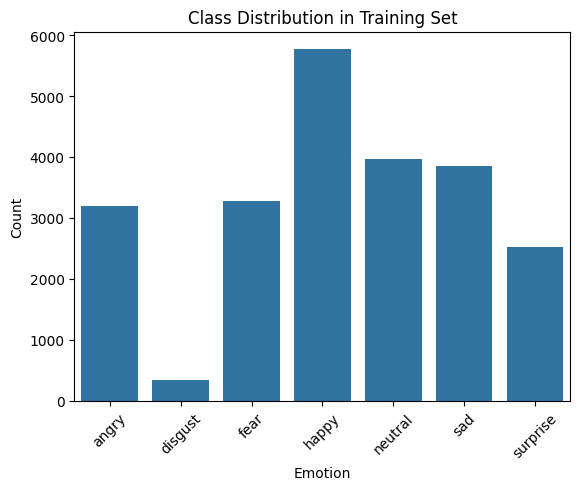

In [15]:
# Check if there is class imbalance
# Get class labels from traingen (not just a batch but all)
labels = traingen.classes
class_indices = traingen.class_indices
class_labels = {v: k for k, v in class_indices.items()}

label_names = [class_labels[label] for label in labels]
sns.countplot(x=label_names, order=sorted(set(label_names)))
plt.title("Class Distribution in Training Set")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

In [89]:
# Add added data augmentation to train dataset to improve robustness
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
)

# keep the rescale only for validation & test data
val_test_datagen = ImageDataGenerator(rescale=1.0 / 255)

In [90]:
# Update the generator
traingen = train_datagen.flow_from_directory(
    DATA_DIR + "/train",
    target_size=target_size,
    batch_size=batch_size,
    class_mode="sparse",
    color_mode="grayscale",
)

valgen = val_test_datagen.flow_from_directory(
    DATA_DIR + "/validation",
    target_size=target_size,
    batch_size=batch_size,
    class_mode="sparse",
    color_mode="grayscale",
)

testgen = val_test_datagen.flow_from_directory(
    DATA_DIR + "/test",
    target_size=target_size,
    batch_size=batch_size,
    shuffle=False,
    class_mode="sparse",
    color_mode="grayscale",
)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [18]:
# Add class weight

labels = traingen.classes
class_weights = compute_class_weight(
    class_weight="balanced", classes=np.unique(labels), y=labels
)
class_weights_dict = dict(enumerate(class_weights))

print(
    "Class weights:", class_weights_dict
)  # we could use this class_weight when we fit the model

Class weights: {0: 1.0266404434114071, 1: 9.401555464592715, 2: 1.0009587727708533, 3: 0.5684585684585685, 4: 0.826068191627104, 5: 0.8491570541259982, 6: 1.2933160650937552}


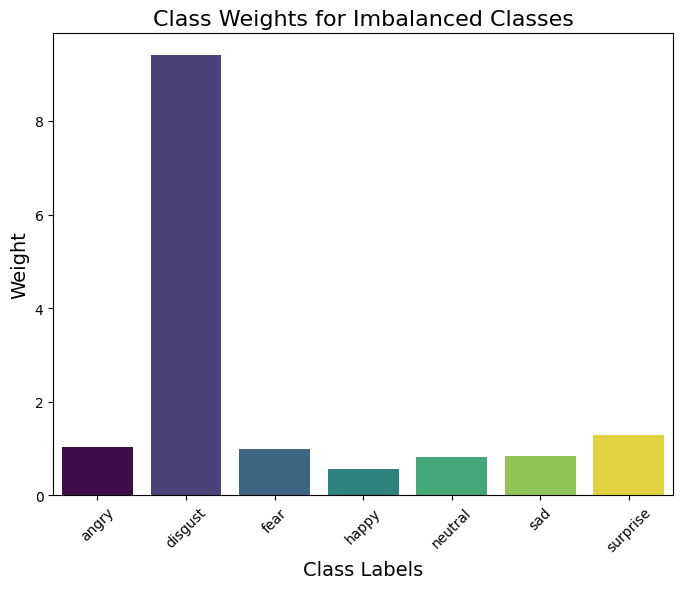

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

labels, values = list(class_weights_dict.keys()), list(class_weights_dict.values())
sns.barplot(x=labels, y=values, hue=labels, palette="viridis")
ax.legend_.remove()
ax.set_xticks(labels, labels=class_labels.values(), rotation=45)

ax.set_title("Class Weights for Imbalanced Classes", fontsize=16)
ax.set_ylabel("Weight", fontsize=14)
ax.set_xlabel("Class Labels", fontsize=14)
plt.show()

As expected, the class weights are inversely proportional to the number of samples in each class. The class weights for `digust` are the largest, while the class weights for `happy` are the smallest. 

### Denoising

#### Non-Local Means Denoising

Non-local means (NLM) is a denoising technique that differs from local filters by considering the entire image for noise reduction. It does so by computing a mean for all pixels in the image, weighted by how similar these pixels are to the target pixel. We attempt to apply this technique to alleviate the water mark issue seen in some of the images. We use OpenCV library which can easily be integrated into tensorflow via a custom layer. We hand pick a set of four images to test this denoising approach. A thorough formulation of this approach can be found in the Appendix.

Watermarks are typically horizontal, and can appear at the top, bottom, or center of the image. Their color could be light, dark, and in some cases, they overlap with facial features. 

In [20]:
watermarked_images = [
    "fear/Training_7118915.jpg",
    "happy/Training_10229138.jpg",
    "neutral/Training_15579995.jpg",
    "sad/Training_20437400.jpg",
]

In [21]:
def read_image(path):
    watermark_img_bytes = tf.io.read_file(path)
    watermark_image_tensor = tf.image.decode_image(watermark_img_bytes, channels=3)

    return watermark_image_tensor

2025-04-01 22:29:52.348530: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2025-04-01 22:29:52.348705: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2025-04-01 22:29:52.348711: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2025-04-01 22:29:52.348734: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-01 22:29:52.348747: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


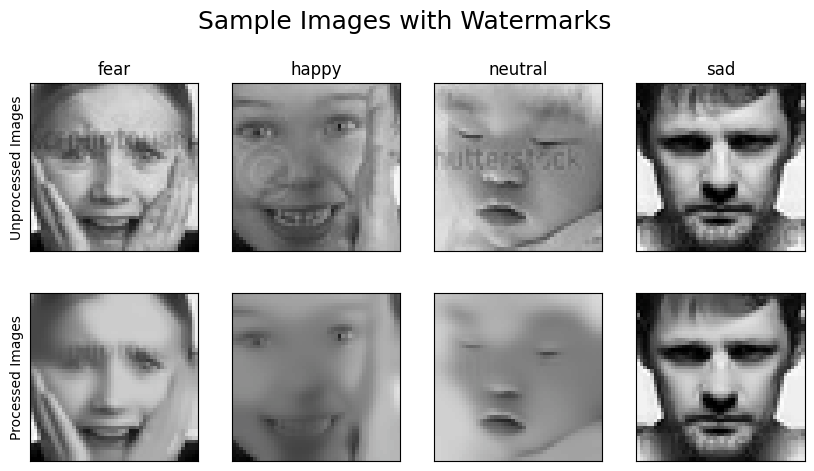

In [22]:
fig, axs = plt.subplots(2, 4, figsize=(10, 5))

counter = 0

for image_path in watermarked_images:
    image = read_image("./data/train/" + image_path)
    axs[0, counter].imshow(image, cmap="gray")
    axs[0, counter].set_title(image_path.split("/")[0])

    denoised_image = cv2.fastNlMeansDenoisingColored(
        image.numpy(),
        None,
        # Strength of the filter
        h=10,
        # Size in pixels of the template patch that is used to compute weights.
        templateWindowSize=7,
        # Size in pixels of the window that is used to compute weighted average for given pixel
        searchWindowSize=21,
    )
    axs[1, counter].imshow(denoised_image, cmap="gray")

    if counter == 0:
        axs[0, 0].set_ylabel("Unprocessed Images")
        axs[1, 0].set_ylabel("Processed Images")

    axs[0, counter].set_xticks([])
    axs[0, counter].set_yticks([])
    axs[1, counter].set_xticks([])
    axs[1, counter].set_yticks([])

    counter += 1

plt.suptitle("Sample Images with Watermarks", y=1.02, fontsize=18)
plt.show()

In [23]:
# check the impact of mask on a image without watermark
non_watermarked_image = read_image(
    os.path.join(DATA_DIR, "train", "surprise", "Training_737165.jpg")
)

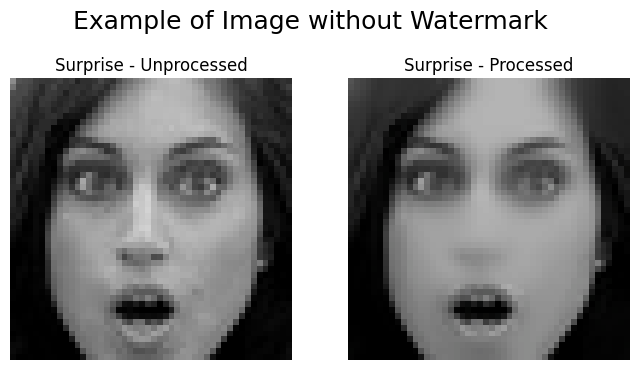

In [24]:
non_watermarked_image_processed = cv2.fastNlMeansDenoisingColored(
    non_watermarked_image.numpy(),
    None,
    # Strength of the filter
    h=12,
    # Size in pixels of the template patch that is used to compute weights.
    templateWindowSize=7,
    # Size in pixels of the window that is used to compute weighted average for given pixel
    searchWindowSize=21,
)


fig, ax = plt.subplots(1, 2, figsize=(8, 4))

ax[0].imshow(non_watermarked_image, cmap="gray")
ax[0].set_title("Surprise - Unprocessed")
ax[0].axis("off")

ax[1].imshow(non_watermarked_image_processed, cmap="gray")
ax[1].set_title("Surprise - Processed")
ax[1].axis("off")

plt.suptitle("Example of Image without Watermark", y=1.02, fontsize=18)
plt.show()

The results are decent but as expected there is a tradeoff. Since facial skin tones tend to be consistent, the method performed fine on the first image. However we lose image detail when we apply NLM. It overly smoothed facial details like bluring eyes, as with the case for the second and third images. The watermark is less visible but the image is also less clear. In the fourth case, the watermark can still be seen. We wrap up the section with an example of an image without a water and as one can see the details are erased.

We tried other strategies like Gaussian denoising but the results were not as good. The image lost detail in addition to not removing the watermark. This approach was omitted from this notebook.

It remains to be determined if the watermark even has a significant impact on future model performance. Since watermarks vary and only affect a small number of images, the approach for now may be to rely on data augmentation to improve generalization and reduce overfitting.

#### Future Work

The strategy going forward will be to train a model without any denoising and then try a model with Gaussian denoising and NLM. If both strategies fail, we will try to use autoencoders to remove the watermark. We will use the watermarked image and the denoised image as training pairs to hopefully create images that are more clear. A simple example of this is found in Lab 6 using Gaussian blur.

### Feature Scaling

We will compare three data preprocessing steps to gauge the baseline model performance. For our very basic baseline model (more details in the next section), we will only normalize the pixel values of our training and validation set.

In [78]:
# just normalizing the pixel values
baseline_datagen = ImageDataGenerator(rescale=1.0 / 255)

baseline_train_datagen = baseline_datagen.flow_from_directory(
    DATA_DIR + "/train",
    target_size=target_size,
    batch_size=batch_size,
    class_mode="sparse",
    color_mode="grayscale",
)

baseline_val_datagen = baseline_datagen.flow_from_directory(
    DATA_DIR + "/validation",
    target_size=target_size,
    batch_size=batch_size,
    class_mode="sparse",
    color_mode="grayscale",
)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.


We will compare the performance using the same basic model architecture trained on data with per image standardization.

In [101]:
def per_image_standardization(image):

    if isinstance(image, np.ndarray):
        image_tensor = tf.convert_to_tensor(image, dtype=tf.float32)
    else:
        image_tensor = image
        
    standardized_image = tf.image.per_image_standardization(image_tensor)

    return standardized_image.numpy()

standardization_datagen = ImageDataGenerator(
    preprocessing_function=per_image_standardization,
)

train_std_datagen = standardization_datagen.flow_from_directory(
    DATA_DIR + "/train",
    target_size=target_size,
    batch_size=batch_size,
    class_mode="sparse",
    color_mode="grayscale"
)

val_std_datagen = standardization_datagen.flow_from_directory(
    DATA_DIR + "/validation",
    target_size=target_size,
    batch_size=batch_size,
    class_mode="sparse",
    color_mode="grayscale"
)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.


Finally, the results will be compared with a model with the same architecture but trained on augmented data with normalized pixel values. The data augmentation code is highlighted in the Data Imbalance section, and we will use the `traingen` and `valgen` generators for that model. 

### Summary

The preprocessing pipeline for our emotion recognition model includes: rescaling, dividing pixel values by 255 to normalize data within the [0,1] range; data augmentation techniques (applied to the training set only), including rotation (20 degrees), width and height shifts (20%), zooming (up to 20%), and horizontal flipping to artificially expand the dataset and improve model generalization. Additionally, per-image standardization is implemented to normalize each image individually, addressing variations in lighting and contrast. We also implemented class weighting to handle the inherent imbalance across emotion categories, ensuring the model won't bias toward majority classes. The dataset is organized into training (22,968), validation (5,741), and test (7,178) sets across seven emotion classes, keeping the target size of 48x48 pixels.

For future work, we could explore advanced preprocessing techniques including facial feature-specific noise reduction, contrastive learning to distinguish similar emotions like fear and surprise, and facial landmark detection to standardize orientation. We can also implemente custom data augmentation strategies that preserve emotion-specific features while varying other aspects, as this would improve our model's ability to generalize.

## Baseline Model

For our model training, we want to make sure that we are utilizing a GPU if available and that our results are reproducible. 

In [96]:
# test if GPU is available
if tf.config.list_physical_devices('GPU'):
    print("GPU available")
else:
    print("No GPU available")

# set seeds for reproducibility
os.environ['PYTHONHASHSEED'] = '0'
os.environ['CUDA_VISIBLE_DEVICES'] = ''
tf.random.set_seed(109)
np.random.seed(109)
set_random_seed(109)

# plot accuracy
def plot_accuracy(history, plot_title = 'Model'):
    """
    Helper function to plot accuracy of a model.
    """

    plt.figure(figsize=(10, 6))

    best_val_acc = np.max(history.history['val_accuracy'])
    best_epoch = np.argmax(history.history['val_accuracy'])

    epochs = range(1, len(history.history['accuracy']) + 1)
    
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
    
    plt.axvline(
        best_epoch + 1,
        color='red', linestyle='--', 
        label=f'Best val acc: {best_val_acc:.4f}'
    )
    
    plt.title(f'{plot_title}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.xticks(epochs)
    plt.legend(loc='lower bright')

GPU available


The baseline model will follow a very basic model architecture taken from the Lab's code. We added one regularization layer and adjusted the outputs, as well as the loss function to account for the classes in our data.

In [97]:
# Very basic model
def create_baseline_model():
    inputs = Input(shape=(48, 48, 1))
    
    x = Conv2D(64, kernel_size=(3, 3), activation='relu')(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(32, kernel_size=(3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(16, kernel_size=(3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(7, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

Training the most basic model with almost unprocessed data, just with the pixel values normalized.

In [ ]:
baseline_model = create_baseline_model(show_summary=True)

baseline_model_history = baseline_model.fit(
    baseline_train_datagen,
    epochs=15, 
    validation_data=baseline_val_datagen,
    verbose=1
)


Epoch 1/15


/Users/santiagobecerracordoba/PycharmProjects/cs109b/.venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


718/718 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.2349 - loss: 1.8372 - val_accuracy: 0.3693 - val_loss: 1.6435
Epoch 2/15
718/718 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.3464 - loss: 1.6582 - val_accuracy: 0.4057 - val_loss: 1.5514
Epoch 3/15
718/718 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.3865 - loss: 1.5828 - val_accuracy: 0.4170 - val_loss: 1.5270
Epoch 4/15
718/718 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.4058 - loss: 1.5513 - val_accuracy: 0.4280 - val_loss: 1.5174
Epoch 5/15
718/718 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.4069 - loss: 1.5443 - val_accuracy: 0.4187 - val_loss: 1.5127
Epoch 6/15
718/718 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.4106 - loss: 1.5428 - val_accuracy: 0.4189 - val_loss: 1.5342
Epoch 7/15
718/718 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.4084 - loss: 1.5551 - val_accuracy: 0.4316 - val_loss: 1.5079
Epoch 8/15
718/718 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.4058 - loss: 1.5660 - val_accuracy: 0.4

Baseline Model with Pixel Normalization
Train Loss: 1.5493, Train Accuracy: 0.4319
Validation Loss: 1.6105, Validation Accuracy: 0.4214


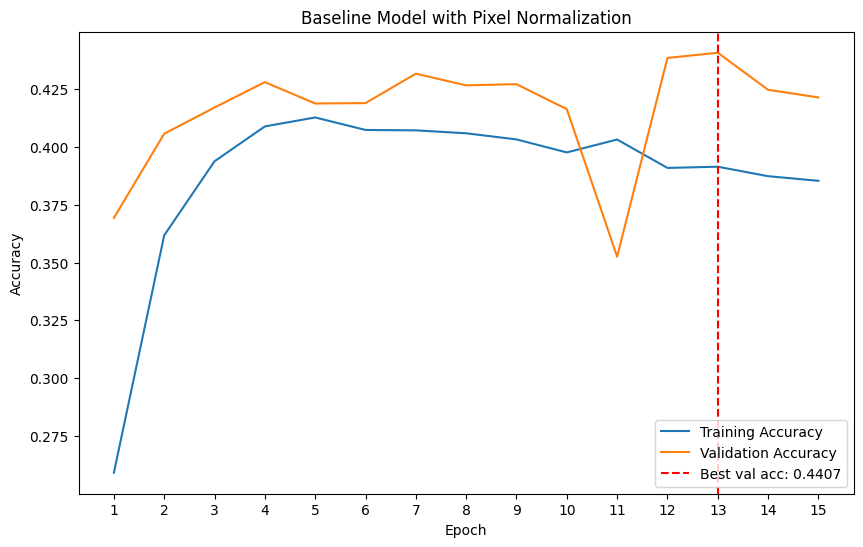

In [87]:

baseline_train_datagen.reset()
train_loss, train_acc = baseline_model.evaluate(baseline_train_datagen, verbose=0)

baseline_val_datagen.reset()
val_loss, val_acc = baseline_model.evaluate(baseline_val_datagen, verbose=0)

print("Baseline Model with Pixel Normalization")
print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

plot_accuracy(baseline_model_history, 'Baseline Model with Pixel Normalization')

With just these results, it is hard to tell how our model is performing. The baseline should at least inform us that: 1) our model and the data generators are working, and 2) without any preprocessing, we get a validation accuracy 44.07% after 13 epochs. However, the fact that the model is not overfitting the training data (training accuracy starts decrasing after 5 epochs) suggests there can be problems in the model implementation. Lucky for us, this is just the baseline, a rough gauge of where we're starting.

Now we want to compare the results using the same architecture, only with a slighly different preprocessing: per image standardization, instead of just dividing pixel values by 255.

In [102]:
baseline_std_model = create_baseline_model()

baseline_std_model_history = baseline_std_model.fit(
    train_std_datagen,
    epochs=15, 
    validation_data=val_std_datagen,
    verbose=1
)


Epoch 1/15


/Users/santiagobecerracordoba/PycharmProjects/cs109b/.venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


718/718 ━━━━━━━━━━━━━━━━━━━━ 61s 84ms/step - accuracy: 0.2612 - loss: 1.7938 - val_accuracy: 0.4250 - val_loss: 1.5047
Epoch 2/15
718/718 ━━━━━━━━━━━━━━━━━━━━ 60s 83ms/step - accuracy: 0.4114 - loss: 1.5308 - val_accuracy: 0.4417 - val_loss: 1.4428
Epoch 3/15
557/718 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - accuracy: 0.4446 - loss: 1.4371

Baseline Model with Per Image Standardization
Train Loss: 1.5109, Train Accuracy: 0.4974
Validation Loss: 1.6387, Validation Accuracy: 0.4646


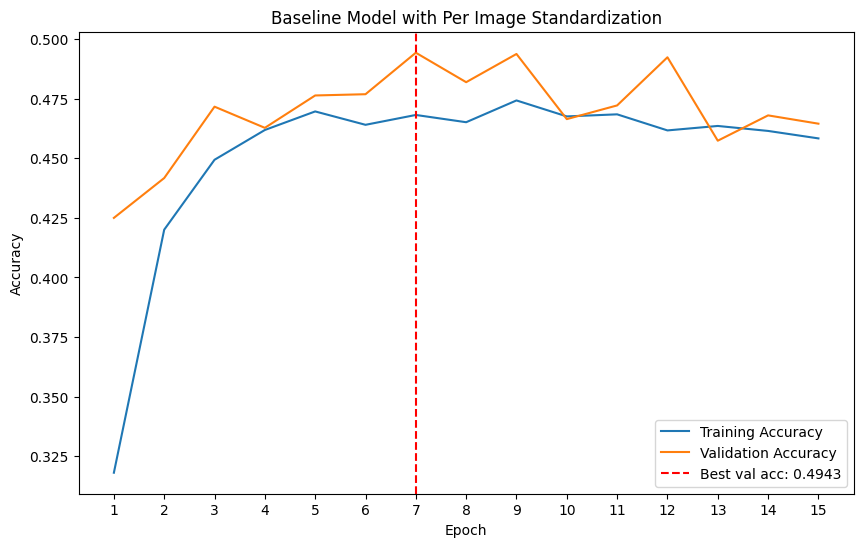

In [104]:
train_std_datagen.reset()
train_loss, train_acc = baseline_std_model.evaluate(train_std_datagen, verbose=0)

val_std_datagen.reset()
val_loss, val_acc = baseline_std_model.evaluate(val_std_datagen, verbose=0)

print("Baseline Model with Per Image Standardization")
print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

plot_accuracy(baseline_std_model_history, 'Baseline Model with Per Image Standardization')

Even though the best reported validation accuracy improved compared to the previous model, the training time increased significantly (as the data flow is now performing more complex calculations on each image). For future steps, we can find ways to optimize this step, if it is going to significantly improve performance. Preliminary results, however, indicate the tradeoff may not be worth it.

Now, we'll use the class weights identified before to train the baseline model and compare performance.

In [105]:
baseline_weighted_model = create_baseline_model()

baseline_weighted_model_history = baseline_weighted_model.fit(
    baseline_train_datagen,
    epochs=15, 
    validation_data=baseline_val_datagen,
    class_weight=class_weights_dict,
    verbose=1
)


Epoch 1/15
718/718 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.1690 - loss: 1.9366 - val_accuracy: 0.2463 - val_loss: 1.8205
Epoch 2/15
718/718 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.2343 - loss: 1.8608 - val_accuracy: 0.3114 - val_loss: 1.7499
Epoch 3/15
718/718 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.2805 - loss: 1.7665 - val_accuracy: 0.3109 - val_loss: 1.7469
Epoch 4/15
718/718 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.3040 - loss: 1.7298 - val_accuracy: 0.2999 - val_loss: 1.7724
Epoch 5/15
718/718 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.3351 - loss: 1.6912 - val_accuracy: 0.3738 - val_loss: 1.6360
Epoch 6/15
718/718 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.3374 - loss: 1.6768 - val_accuracy: 0.3202 - val_loss: 1.7389
Epoch 7/15
718/718 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.3522 - loss: 1.6443 - val_accuracy: 0.3839 - val_loss: 1.5889
Epoch 8/15
718/718 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.3578 - loss: 1.6206 - va

Baseline Model with Class Weighting
Train Loss: 1.5728, Train Accuracy: 0.4140
Validation Loss: 1.6583, Validation Accuracy: 0.3879


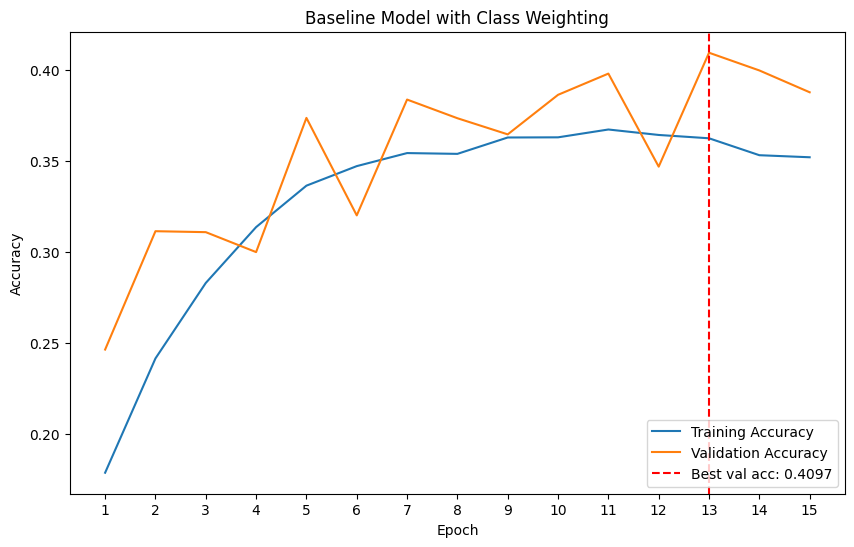

In [106]:
baseline_train_datagen.reset()
train_loss, train_acc = baseline_weighted_model.evaluate(baseline_train_datagen, verbose=0)

baseline_val_datagen.reset()
val_loss, val_acc = baseline_weighted_model.evaluate(baseline_val_datagen, verbose=0)

print("Baseline Model with Class Weighting")
print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

plot_accuracy(baseline_weighted_model_history, 'Baseline Model with Class Weighting')

Training using the class weights impacted the stability of the validation accuracy, which fluctuates more. This is expected, as the impact of minority classes in different batches is accentuated by the weights. Performance is comparable, and suggests this is an avenue worth exploring when we are testing more robusts models down the line.

Finally, we compare the baseline model by training it with augmented data.

In [107]:
baseline_aug_model = create_baseline_model()

baseline_aug_model_history = baseline_aug_model.fit(
    traingen,
    epochs=15, 
    validation_data=valgen,
    class_weight=class_weights_dict,
    verbose=1
)



Epoch 1/15
718/718 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.1505 - loss: 1.9455 - val_accuracy: 0.2003 - val_loss: 1.9002
Epoch 2/15
718/718 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.1637 - loss: 1.9327 - val_accuracy: 0.2271 - val_loss: 1.8782
Epoch 3/15
718/718 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.2137 - loss: 1.8559 - val_accuracy: 0.2040 - val_loss: 1.8600
Epoch 4/15
718/718 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.2134 - loss: 1.8730 - val_accuracy: 0.2129 - val_loss: 1.8819
Epoch 5/15
718/718 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.2204 - loss: 1.8762 - val_accuracy: 0.2136 - val_loss: 1.8475
Epoch 6/15
718/718 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.2353 - loss: 1.8316 - val_accuracy: 0.2263 - val_loss: 1.8575
Epoch 7/15
718/718 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.2597 - loss: 1.7938 - val_accuracy: 0.2947 - val_loss: 1.7587
Epoch 8/15
718/718 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.2742 - loss: 1.7754 - val_acc

Baseline Model with Data Augmentation and Pixel Normalization
Train Loss: 1.5681, Train Accuracy: 0.3820
Validation Loss: 1.4827, Validation Accuracy: 0.4259


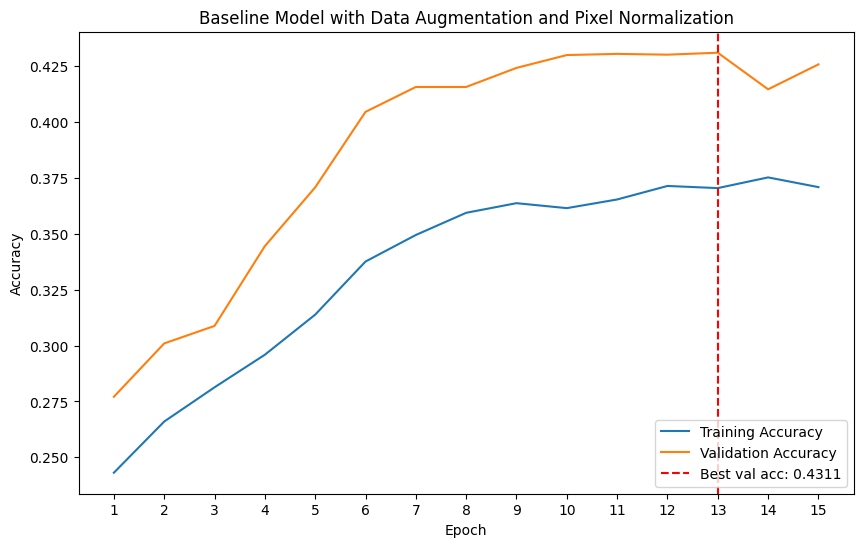

In [93]:

traingen.reset()
train_loss, train_acc = baseline_aug_model.evaluate(traingen, verbose=0)

valgen.reset()
val_loss, val_acc = baseline_aug_model.evaluate(valgen, verbose=0)

print("Baseline Model with Data Augmentation and Pixel Normalization")
print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

plot_accuracy(baseline_aug_model_history, 'Baseline Model with Data Augmentation and Pixel Normalization')

Performance is comparable and more stable when training with augmented data, suggesting that we could get better results by training with more epochs and more complex architectures.

Overall, the performance with a very basic architecture is similar regardless of the data processing, with minor differences in stability and accuracy. Looking forward, we may want to explore transfer learning, as there are models already trained on millions of images that are able to detect features that our basic models simply can't.  But these baseline model provide us with a rough idea of where we're starting and how much there is to improve.

## Sources

1. https://en.wikipedia.org/wiki/Non-local_means
2. https://docs.opencv.org/3.4/d1/d79/group__photo__denoise.html#ga03aa4189fc3e31dafd638d90de335617

## Appendix

### Mathematical Formulae

For our case, since we use normalization our pixel values are continous. The NLM algorithm is defined as the following transformation. Let $u(p)$ be the transformed pixel value at position $p$ in the image. $C(p)$ is a normalizing constant and $\Omega$ is the set of pixels in the image. $v(q)$ is the untransformed pixel.

$$
u(p) = \frac{1}{C(p)} \int_{q \in \Omega} v(q) \cdot w(p,q) dq
$$

The weight function $w(p,q)$ is defined as follows:

$$
w(p,q) = exp(- \frac{|B(q) - B(p)|^2}{h^2}).
$$

$h$ is the parameter we pass into the NLM function. It controls the strength of the denoising. A larger value of $h$ means more smoothing and less detail. $B(p)$ is a patch of pixels around the pixel p. The size of the patch is defined by the parameter `templateWindowSize`. $B(q)$ is a patch of pixels around the pixel q. The size of the patch is defined by the parameter `searchWindowSize`. The weight measures how similar the patches $B(p)$ and $B(q)$ are. The weight will be larger if the patches are more similar.
